**Agentic Clarify Coder**

Developed a Agentic ClarifyCoder, a workflow centered on ClarifyCoder a fine-tuned model that explicitly flags uncertainty and asks targeted clarification questions before generating any code. The system adopts a “code-when-certain, ask-when-unsure” posture: it produces code immediately for well-specified prompts, and uses short, focused questions to elicit missing user requirements when ambiguity is detected. The workflow coordinates two agents: Agent 1 reviews the question and, if it is clear, sends it to Agent 2; if it is not, Agent 1 asks clarification questions to the user. Agent 2 generates the code by using user input once ambiguity is resolved. This disciplined clarify-then-code loop reduces brittle guesses, lowers error rates, and measurably improves the reliability and user trust of LLM-based code generation.

In [4]:
!pip -q install transformers peft langgraph langchain-core langchain-community


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 24.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [5]:
import torch, os
from typing import TypedDict, List, Dict, Any
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from langgraph.graph import StateGraph, END
from graphviz import Digraph
from IPython.display import Image, display
import re

**Initializing Clarify Coder**

In [6]:
Base_model  = "deepseek-ai/deepseek-coder-6.7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(Base_model, use_fast=True, trust_remote_code=True)

#Loading the Deepseek-coder model
base_model = AutoModelForCausalLM.from_pretrained(
    Base_model,
    dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
    trust_remote_code=True,
)

#Loading Clarify-Coder Adaper
model = PeftModel.from_pretrained(base_model, "jie-jw-wu/clarify-coder").eval()
device = next(model.parameters()).device


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

**Function to Generate response from language model**



In [7]:
def response(messages: list[dict[str, str]],max_new_tokens: int,temperature: float) -> str:

    prompt = tokenizer.apply_chat_template(messages,tokenize=False,add_generation_prompt=True)

    #Tokenizing the Prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    #Generating Output
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=0.95,
            do_sample=(temperature > 0),
            repetition_penalty=1.05,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=(tokenizer.pad_token_id or tokenizer.eos_token_id),
        )

    #Decoding the generated output to text
    full_sequence = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return full_sequence[len(prompt):].strip() if full_sequence.startswith(prompt) else full_sequence.strip()


**Two Agentic Flow**

**TwoState Class manages the shared state in the Agentic workflow,**

In [8]:
#Shared state
class TwoState(TypedDict, total=False):
    problem: str
    answers: str
    questions: str
    needs_clarification: bool
    final_code: str
    status: str

**Agent1**

This agent will understand the user problem and generate clarify question if Problem is unclear if not generate OK

In [14]:
def AnalyzerAgent1(state: TwoState) -> TwoState:
    """Agent 1: Question Analyzer - determines if problem is clear or needs clarification"""

    system_msg = {
        "role": "system",
        "content": (
            "You are a problem analyzer. Determine if the problem is clear enough to code.\n\n"
            "OUTPUT RULES:\n"
            "- If the problem is clear and specific, respond EXACTLY: OK\n"
            "- If the problem is vague or missing details, ask 1-4 numbered questions\n"
            "- Format questions as: '1. Question here\\n2. Another question\\n'\n"
            "- NO explanations, NO code, NO other text\n\n"

            "Examples of CLEAR problems (respond OK):\n"
            "- 'Write a function to add two numbers 4 and 5'\n"
            "- 'Create a function to reverse a string Amercia'\n"
            "- 'Find the maximum number in a list of 5 elements'\n\n"

            "Examples of UNCLEAR problems (ask questions):\n"
            "- Return the list increment by number (what number?)\n"
            "- 'Sort an array' (which algorithm? ascending/descending?)\n"
            "- 'Create a calculator' (what operations? GUI or CLI?)\n"
            "- 'Process data' (what kind of processing? what format?)\n\n"
            "Only ask questions if genuinely ambiguous."
        )
    }

    user_msg = {
        "role": "user",
        "content": f"Analyze this problem: {state['problem']}\n\nIs this clear enough to implement without ambiguity?"
    }

    # Generate analysis
    raw_output = response([system_msg, user_msg], max_new_tokens=300, temperature=0.0).strip()

    # Clean up the output
    lines = [line.strip() for line in raw_output.split('\n') if line.strip()]

    # Check if it's OK
    if any(line.upper() == "OK" for line in lines):
        out_final = "OK"
        needs = False
        print("Agent 1: Problem is CLEAR - OK")
    else:
        # Extract numbered questions
        questions = []
        for line in lines:
            if re.match(r'^[1-4]\.\s+', line):
                questions.append(line)

        if questions and len(questions) <= 4:
            out_final = '\n'.join(questions)
            needs = True
            print("Agent 1: Problem is UNCLEAR - Questions needed")
            print(out_final)
        else:
            # Default to OK if no clear questions
            out_final = "OK"
            needs = False
            print("Agent 1: Defaulting to OK")

    # Update state
    new = dict(state)
    new["needs_clarification"] = needs
    new["questions"] = out_final if needs else ""
    if needs and not state.get("answers"):
        new["status"] = "awaiting_answers"

    return new

The route function directs the workflow after Agent 1 sending it to await for user requirements or to refine for final code generation.

In [15]:
# Simple 2-agent workflow routing
def route_after_agent1(state: TwoState) -> str:
    if state.get("needs_clarification") and not state.get("answers"):
        return "await"
    return "generate_code"

def await_for_user_input(state: TwoState) -> TwoState:
    new = dict(state)
    new["status"] = "awaiting_answers"
    return new

**Agent 2**

This agent will complete the final code by understanding the problem statement and user requirements.

In [16]:
#Agent 2
def CoderAgent2(state: TwoState) -> TwoState:
    """Agent 2: Code Generator - generates executable code based on problem and requirements"""

    system_msg = {
        "role": "system",
        "content": (
            "You are a Python code generator. Create complete, executable Python code.\n\n"
            "RULES:\n"
            "- Generate ONE complete, working Python program\n"
            "- If user provided requirements, implement them exactly\n"
            "- Write clean, production-ready code\n"
            "- Start directly with the code\n\n"
            "Create a complete solution that works immediately."
        )
    }

    # Create prompt based on whether user provided requirements
    if state.get('questions') and state.get('answers'):
        print("Agent 2: Generating code with USER REQUIREMENTS")
        prompt = (
            f"Create Python code that implements the user's specific requirements.\n\n"
            f"PROBLEM: {state['problem']}\n\n"
            f"QUESTIONS ASKED: {state['questions']}\n\n"
            f"USER REQUIREMENTS: {state['answers']}\n\n"
            f"TASK: Create complete Python code that follows the user's specifications exactly. "
            f"Implement each requirement they provided."
        )
    else:
        print("Agent 2: Generating code for CLEAR PROBLEM")
        prompt = (
            f"Create Python code for this clear problem.\n\n"
            f"PROBLEM: {state['problem']}\n\n"
            f"TASK: Create complete, executable Python code that solves this problem. "
            f"Include example usage."
        )

    # Generate code
    raw_output = response([system_msg, {"role": "user", "content": prompt}], max_new_tokens=1500, temperature=0.0).strip()

    # Clean up the output using your existing clean function
    code_pattern = re.compile(r"(?:```python\s*\n(.*?)\n\s*```|### Response:\s*\n(.*))", re.DOTALL)
    match = code_pattern.search(raw_output)
    if match:
        final_code = (match.group(1) or match.group(2)).strip()
    else:
        final_code = raw_output.strip()



    # Update state
    new = dict(state)
    new["final_code"] = final_code
    new["status"] = "finalized"
    return new

**StateGraph**

Building StateGraph for Two Agentic Workflow, Connecting Agent1, Agent2 with conditional routing to handle clarifications and finalize Code

In [17]:
#Build the graph
builder = StateGraph(TwoState)
builder.add_node("AnalyzerAgent1", AnalyzerAgent1)  # Question analyzer
builder.add_node("CoderAgent2", CoderAgent2)  # Code generator
builder.add_node("await_for_user_input", await_for_user_input)
builder.set_entry_point("AnalyzerAgent1")
builder.add_conditional_edges("AnalyzerAgent1", route_after_agent1, {"await": "await_for_user_input", "generate_code": "CoderAgent2"})
builder.add_edge("await_for_user_input", END)
builder.add_edge("CoderAgent2", END)
clarify_graph = builder.compile()

**Vizualize State Grpah**

In [18]:

from graphviz import Digraph

# Create a new directed graph
dot = Digraph(comment='ClarifyCoder StateGraph', format='png')

# Define nodes
dot.node('AnalyzerAgent1', 'AnalyzerAgent1\n(Problem Analyzer)', shape='box', style='filled', fillcolor='lightblue')
dot.node('CoderAgent2', 'CoderAgent2\n(Code Generator)', shape='box', style='filled', fillcolor='lightgreen')
dot.node('await_for_user_input', 'Await User Input', shape='box', style='filled', fillcolor='lightyellow')
dot.node('END', 'END', shape='circle', style='filled', fillcolor='red')

# Define edges
dot.edge('AnalyzerAgent1', 'CoderAgent2', label='generate_code', style='bold')
dot.edge('AnalyzerAgent1', 'await_for_user_input', label='await (unclear)', style='dashed')
dot.edge('await_for_user_input', 'CoderAgent2', label='proceed after input', style='dotted')
dot.edge('CoderAgent2', 'END')

# Set entry point (visual cue)
dot.node('START', 'START', shape='circle', style='filled', fillcolor='grey')
dot.edge('START', 'AnalyzerAgent1', label='Entry', style='bold')

# Render the graph to a file
dot.render('TwoAgent', view=True)

'TwoAgent.png'

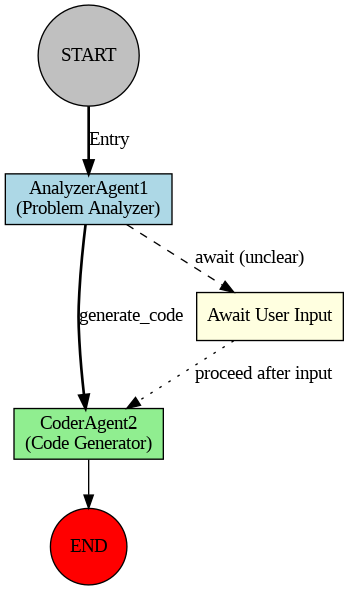

In [19]:
display(Image(filename='TwoAgent.png'))

**Two Agentic Workflow**

This function manually executes the Two Agentic workflow, reviewing the user question with Agent1, collecting user clarification if needed, and producing final code with Agent2.

In [30]:
def agentic_clarify_coder(problem: str):
    """Run the 2-agent ClarifyCoder workflow"""

    print(f"Processing problem: {problem}\n")

    #Agent 1 analyzes the problem
    print("Agent 1: Analyzing problem clarity...")
    state = {"problem": problem}
    state = AnalyzerAgent1(state)
    print("="*50)

    # Handle clarification if needed
    if state.get("needs_clarification"):
        print("Clarifying questions:")
        print(state["questions"])
        print("="*50)

        # Get user input
        print("Please provide answers to the questions above:")
        answers = input("Your answers: ")

        # Add answers to state
        state["answers"] = answers
        print(f"Received answers: {answers[:100]}...")
        print("="*50)

    #Agent 2 generates the code
    print("🔧 Agent 2: Generating code...")
    state = CoderAgent2(state)

    # Output final code
    if state.get("final_code"):
        print("\nFinal Code:")
        print("-" * 40)
        print(state["final_code"])
        return state["final_code"]
    else:
        print("Error: Could not generate final code")
        return None
        if state.get("final_code") == "":
            print("Final code is empty string")
        return None

In [34]:
if __name__ == "__main__":
    result1 = agentic_clarify_coder("Write a python code to sort a list")

Processing problem: Write a python code to sort a list

Agent 1: Analyzing problem clarity...
Agent 1: Problem is UNCLEAR - Questions needed
1. What type of sorting should be performed on the list?
2. Is the list already sorted in ascending or descending order?
3. Are there any specific conditions or rules for sorting that need to be followed?
Clarifying questions:
1. What type of sorting should be performed on the list?
2. Is the list already sorted in ascending or descending order?
3. Are there any specific conditions or rules for sorting that need to be followed?
Please provide answers to the questions above:
Your answers: 1. descending, 2. no, 3.use merge sort
Received answers: 1. descending, 2. no, 3.use merge sort...
🔧 Agent 2: Generating code...
Agent 2: Generating code with USER REQUIREMENTS

Final Code:
----------------------------------------
Sure, here is the Python code that meets your requirements:

```python
def merge_sort(lst):
    if len(lst) <= 1:
        return lst

 

**Okanagan Agentic Flow**

This approach uses the Okanagan workflow. The Agent 1 will create the draft code based on the initial problem statement, providing a preliminary solution without making assumptions. Agent 2 will then evaluate the draft code to determine if it fully addresses the problem. If the draft does not solve the problem or contains ambiguities, Agent 2 generates concise, targeted clarification questions to elicit missing user requirements. Once the user provides the necessary clarifications, Agent 2 sends these requirements to Agent 3. If the draft is deemed sufficient, Agent 2 directly forwards it to Agent 3 without additional questions. Agent 3 then generates the final, production-ready code, incorporating the draft and any clarified requirements, ensuring a robust and reliable output.

**OkState Class manages the shared state in the Okanagan workflow,**

In [21]:
#Shared state
class OkState(TypedDict, total=False):
    problem: str
    answers: str
    draft_code: str
    questions: str
    needs_clarification: bool
    final_code: str
    status: str

**Agent1**

This agent will understand the user problem and generate the draft code for it

In [22]:

def Agent1(state: OkState) -> OkState:

    system_msg = {
        "role": "system",
        "content": (
            "You are a Python developer. Create a step by step draft code that solves the problem.\n\n"
            "RULES:\n"
            "- Write a Code that addresses the problem.\n"
            "- Write a detailed algorithm that solves the problem without using inbuilt functions"
            "- Use generic parameter names (like 'arr', 'data', 'items') instead of input values\n"
            "- DO NOT include specific values or test data given in problem\n"
            "- DO NOT make assumptions about specific requirements\n"
            "- Keep the implementation basic and general\n"
            "- No example calls or test data\n\n"
            "NOTE Anyways generate the draft code"
        )
    }

    user_msg = {
        "role": "user",
        "content": f"Create a Python code for: {state['problem']}"
    }


    #Generating Draft code
    raw = response([system_msg, user_msg], max_new_tokens=1200, temperature=0.1).strip()

    #Extract the code in between ```python ```
    # Extract code between ```python ... ``` or after ### Response:
    code_pattern = re.compile(r"(?:```python\s*\n(.*?)\n\s*```|### Response:\s*\n(.*))", re.DOTALL)
    match = code_pattern.search(raw)
    if match:
        final_code = (match.group(1) or match.group(2)).strip()
    else:
        final_code = final_code.strip()

    #print(final_code)
    #Update state with the draft code
    new = dict(state)
    new["draft_code"] = final_code
    return new

**Agent 2**

This agent acts as a code reviewer to determine if Agent 1 fully solved the problem or if additional requirements are needed for a better outcome.

In [23]:
#Agent 2
def Agent2(state: OkState) -> OkState:

    #Define system message for strict code review, enforcing "OK" or 1-4 Questions
    system_msg = {
        "role": "system",
        "content": (
            "You are a balanced code reviewer. Analyze if the problem is clear enough to implement.\n\n"
            "OUTPUT RULES:\n"
            "- If the problem is clear and can be implemented without ambiguity, respond EXACTLY: OK\n"
            "- If the problem is vague or missing critical details, ask 1-4 numbered questions\n"
            "- Format questions as: '1. Question here\\n2. Another question\\n'\n"
            "- NO explanations, NO code, NO other text\n\n"
            "Examples of CLEAR problems (respond OK):\n"
            "- 'Write a function to add two numbers values are 1 and 2'\n"
            "- 'Create a function to reverse a string America'\n"
            "- 'Write code to find the maximum number in a list'\n\n"
            "Examples of UNCLEAR problems (ask questions):\n"
            "- 'Sort an array' (which algorithm? ascending/descending?)\n"
            "- 'Process user data' (what kind of processing? what format?)\n"
            "- 'Create a calculator' (what operations? GUI or CLI?)\n\n"
            "Only ask questions if there are genuinely multiple ways to interpret the problem."
        )
    }

    prompt = (
        f"Review this problem for clarity:\n\n"
        f"PROBLEM: {state['problem']}\n\n"
        f"DRAFT CODE:\n{state['draft_code']}\n\n"
        f"Is this problem clear enough to implement without ambiguity? "
        f"If yes, respond 'OK'. If no, ask specific clarifying questions."
    )


    # Generate review output using the Clarify Coder
    raw_output = response([system_msg, {"role": "user", "content": prompt}], max_new_tokens=2000, temperature=0.2).strip()


    #Extracting the Response
    code = re.compile(r"(?:###\s*Response:\s*(.*))|(?:Clarifying questions:\s*\n(.*))",
                  re.DOTALL | re.IGNORECASE)
    searching = code.search(raw_output)
    out = (searching.group(1) or searching.group(2)).strip() if searching else raw_output.strip()

    # Filtering the questions
    lines = [ln.strip() for ln in out.splitlines() if ln.strip()]
    question = [ln for ln in lines if re.match(r"^[1-4]\.\s+\S", ln)]
    exact_ok = any(ln == "OK" for ln in lines)

    #If Valid Questions, Set clarification path else OK
    if 1 <= len(question) <= 4:
        out_final = "\n".join(question)
        needs = True
    else:
        out_final = "OK"
        needs = False



    #updating the states
    new = dict(state)
    new["needs_clarification"] = needs
    new["questions"] = out_final if needs else ""
    if needs and not state.get("answers"):
        new["status"] = "awaiting_answers"



    return new

The route function directs the workflow after Agent 2 sending it to await for user requirements or to refine for final code generation.

In [24]:
#Direct Workflow based on needs
def route(state: OkState) -> str:
    if state.get("needs_clarification") and not state.get("answers"):
        return "await"
    return "refine"

#Pass state through while waiting for user input
def await_for_user_input(state: OkState) -> OkState:
    """This node just passes through the state when waiting for user input"""
    new = dict(state)
    new["status"] = "awaiting_answers"
    return new

**Agent 3**

This agent will complete the final code by understanding the problem statement, draft code, and user requirements.


In [25]:
def Agent3(state: OkState) -> OkState:
    # System message: Instruct model to output only executable Python code
    system_msg = {
        "role": "system",
        "content": (
            """You are Agent 3: Final Code Generator. Your job is to create executable Python code.\n\n"
            "CRITICAL RULES:\n"
            "- If USER ANSWERS are provided, you MUST implement them exactly\n"
            "- Do NOT just copy the draft code - MODIFY it based on user requirements\n"
            "- Each user answer specifies a requirement you must implement\n"
            "- Generate complete, working Python code\n"
            "- Include example usage\n"
            "- NO explanations or markdown\n"
            "- Start directly with code\n\n"
            "Your output must reflect ALL user requirements, not just the draft."""
        ),
    }

    # Create prompt based on whether clarifications exist
    if state.get('questions') and state.get('answers'):
      prompt = (
            f"You must create code that implements the user's specific requirements.\n\n"
            f"ORIGINAL PROBLEM: {state['problem']}\n\n"
            f"QUESTIONS ASKED:\n{state['questions']}\n\n"
            f"USER'S SPECIFIC REQUIREMENTS:\n{state['answers']}\n\n"
            f"CRITICAL TASK:\n"
            f"The user has provided specific answers about how they want the code to work. "
            f"You MUST implement their requirements exactly. Do NOT just return the draft code. "
            f"Analyze each user answer and implement those specific requirements.\n\n"
            f"For example:\n"
            f"- If they specified 'bubble sort', implement bubble sort algorithm\n"
            f"- If they specified 'ascending order', sort in ascending order\n"
            f"- If they specified input format, use that exact format\n\n"
            f"Create complete Python code that follows their specifications:"
        )
    else:
      prompt = (
             f"TASK: Convert draft algorithm into executable Python code.\n\n"
            f"PROBLEM: {state['problem']}\n\n"
            f"DRAFT ALGORITHM:\n{state.get('draft_code', '')}\n\n"
            f"INSTRUCTIONS:\n"
            f"1. Make it fully executable and complete\n"
            f"2. Add proper implementation details\n"
            f"3. Add example usage with sample data\n\n"
            f"Generate the complete executable Python code:"
        )

    # Generate final code using the clarify-coder model
    final_code = response([system_msg, {"role": "user", "content": prompt}], max_new_tokens=1500, temperature=0.0).strip()

    def compile_lang_pattern(lang: str) -> re.Pattern:
      lang = re.escape(lang)
      return re.compile(
        rf"(?:```{lang}\s*\n(.*?)\n\s*```)|(?:^###\s*Response:\s*\n(.*))",
        re.DOTALL | re.IGNORECASE | re.MULTILINE
    )

    code_pattern = compile_lang_pattern("python")
    m = code_pattern.search(final_code)
    final_code = (m.group(1) or m.group(2)).strip() if m else final_code.strip()


    # Update state with final code and status
    new = dict(state)
    new["final_code"] = final_code
    new["status"] = "finalized"


    return new

**StateGraph**

Building StateGraph for Okanagan Workflow, Connecting Agent1, Agent2, Agent3 with conditional routing to handle clarifications and finalize Code

In [26]:
#Build the graph
builder = StateGraph(OkState)
builder.add_node("Agent1", Agent1)
builder.add_node("Agent2", Agent2)
builder.add_node("Agent3", Agent3)
builder.add_node("await_for_user_input", await_for_user_input)
builder.set_entry_point("Agent1")
builder.add_edge("Agent1", "Agent2")
builder.add_conditional_edges("Agent2", route, {"await": "await_for_user_input", "refine": "Agent3"})
builder.add_edge("await_for_user_input", END)
builder.add_edge("Agent3", END)
okanagan_graph = builder.compile()

In [27]:
# Create a new directed graph
dot = Digraph(comment='Okanagan StateGraph', format='png')

# Define nodes
dot.node('Agent1', 'Agent1\n(Generate Draft Code)', shape='box', style='filled', fillcolor='lightblue')
dot.node('Agent2', 'Agent2\n(Clarification)', shape='box', style='filled', fillcolor='lightgreen')
dot.node('Agent3', 'Agent3\n(Executer)', shape='box', style='filled', fillcolor='lightyellow')
dot.node('await_for_user_input', 'Await User Input', shape='box', style='filled', fillcolor='lightgrey')
dot.node('END', 'END', shape='circle', style='filled', fillcolor='red')

# Define edges
dot.edge('Agent1', 'Agent2')
dot.edge('Agent2', 'Agent3', label='refine (clear)', style='bold')
dot.edge('Agent2', 'await_for_user_input', label='await (unclear)', style='dashed')
dot.edge('await_for_user_input', 'Agent3', label='proceed after input', style='dotted')
dot.edge('Agent3', 'END')

# Set entry point
dot.node('START', 'START', shape='circle', style='filled', fillcolor='grey')
dot.edge('START', 'Agent1', label='Entry', style='bold')

# Render the graph to a file
dot.render('Three_agent_graph.png', view=True)
print("Graph visualization saved as Three_agent_graph.png")

Graph visualization saved as Three_agent_graph.png


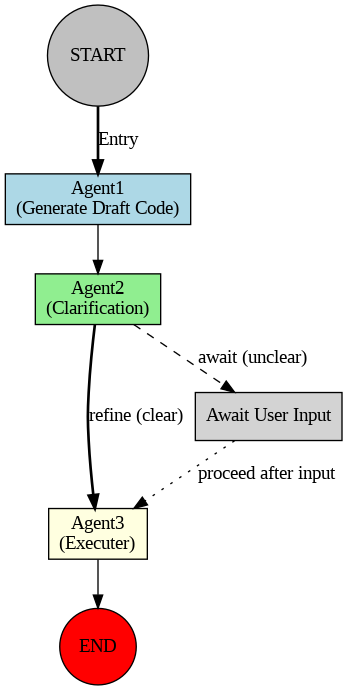

In [28]:
display(Image(filename='Three_agent_graph.png.png'))

**Okanagan Workflow**

This function manually executes the Okanagan workflow, generating a draft with Agent1, reviewing it with Agent2, collecting user clarification if needed, and producing final code with Agent3.

In [29]:
#Run Okanagan workflow interactively

def run_okanagan_interactive(problem: str):
    """Run the Okanagan technique with interactive clarification"""

    print(f"Processing problem: {problem}\n")

    #Generate initial draft
    print("Generating initial draft")
    state = {"problem": problem}
    state = Agent1(state)
    print(f"Draft generated: {len(state['draft_code'])} characters")
    print("\n" + "="*50)

    # Reviewing the draft
    print("Reviewing draft")
    state = Agent2(state)

    # Show if clarification is needed
    if state.get("needs_clarification"):
        print("Reviewer says: NEEDS CLARIFICATION")
    else:
        print("Reviewer says: OK - No clarification needed")
    print("\n" + "="*50)

    # Collect user answer if clarification is needed
    if state.get("needs_clarification"):
        print("Clarifying questions:")
        print(state["questions"])
        print("\n" + "="*50)

        # Getting user input
        print("Please provide answers to the questions above:")
        answers = input("Your answers: ")

        # Adding answers to state
        state["answers"] = answers
        print(f"Received answers: {answers[:100]}...")



    # Generate final code
    print(" Generating final code...")


    state = Agent3(state)

    #Output final Code
    if state.get("final_code"):
        print("\nFinal Code:")
        print("-" * 40)
        print(state["final_code"])
        return state["final_code"]
    else:
        print("Error: Could not generate final code")
        print("Debug - Final state keys:", list(state.keys()))
        if state.get("final_code") == "":
            print("Final code is empty string")
        return None

In [ ]:

if __name__ == "__main__":
    result1 = run_okanagan_interactive("Write a python code to sort the array")

Processing problem: Write a python code to sort the array

Generating initial draft
Draft generated: 352 characters

Reviewing draft
Reviewer says: NEEDS CLARIFICATION

Clarifying questions:
1. What is the sorting algorithm used by the `sort()` function?
2. Is the sorting done in ascending or descending order?
3. Is the sorting case sensitive?
4. Are non-numeric characters included in the sorting process?

Please provide answers to the questions above:
Your answers: 1. merge sort, 2. descending,3.no,4.no
Received answers: 1. merge sort, 2. descending,3.no,4.no...
 Generating final code...

Final Code:
----------------------------------------
```python
def custom_sort(arr):
    arr.sort(reverse=True)
    return arr

# Example usage
print(custom_sort(['c', 'a', 'd', 'b']))  # Output: ['d', 'c', 'b', 'a']
```


**Result**

The Okanagan flow remains a strong baseline: its three-agent structure encourages careful requirement checking and often yields high-quality code when specs are clear. However, because there are more agents, the response time increases and with LLMs inherent fuzziness, small variations from any single agent can propagate, occasionally lowering overall consistency

Building from Okanagan, I developed a two-agent clarifyCoder flow. if the problem is not clear it asks brief clarifications up front and then generating code directly, it uses fewer hops, achieves lower latency, and shows more consistent outputs across runs. In practice, this streamlined graph reduces failure modes, minimizes stochastic drift between stages, and keeps the solution tightly aligned with the clarified requirements.